In [1]:
import os
import glob
import numpy as np

# Define the path to your training data
# The '../' goes up one level from 'notebooks/' to the project root
train_data_path = "../data/main/train/"

# Get a list of all captcha image paths
image_paths = sorted(glob.glob(os.path.join(train_data_path, "*.png")))
print(f"Found {len(image_paths)} images in the training folder.")

# --- Task: Extract all labels and create the character vocabulary ---

# 1. Get all labels from the filenames
labels = [os.path.basename(path).split('-')[0] for path in image_paths]

# 2. Find all unique characters present in the dataset
all_characters = set()
for label in labels:
    for char in label:
        all_characters.add(char)

# Convert the set to a sorted list to ensure consistent mapping
vocabulary = sorted(list(all_characters))

print(f"\nNumber of unique characters found: {len(vocabulary)}")
print(f"Vocabulary: {''.join(vocabulary)}")

# 3. Create the character-to-number and number-to-character dictionaries
char_to_num = {char: i + 1 for i, char in enumerate(vocabulary)}
# We add a dummy character at index 0 for the CTC 'blank' token
num_to_char = {i + 1: char for i, char in enumerate(vocabulary)}

print("\nCharacter to Number Mapping (char_to_num):")
print(char_to_num)

print("\nNumber to Character Mapping (num_to_char):")
print(num_to_char)

Found 8010 images in the training folder.

Number of unique characters found: 36
Vocabulary: 0123456789abcdefghijklmnopqrstuvwxyz

Character to Number Mapping (char_to_num):
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'x': 34, 'y': 35, 'z': 36}

Number to Character Mapping (num_to_char):
{1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'a', 12: 'b', 13: 'c', 14: 'd', 15: 'e', 16: 'f', 17: 'g', 18: 'h', 19: 'i', 20: 'j', 21: 'k', 22: 'l', 23: 'm', 24: 'n', 25: 'o', 26: 'p', 27: 'q', 28: 'r', 29: 's', 30: 't', 31: 'u', 32: 'v', 33: 'w', 34: 'x', 35: 'y', 36: 'z'}


Original image shape: (80, 540, 3)


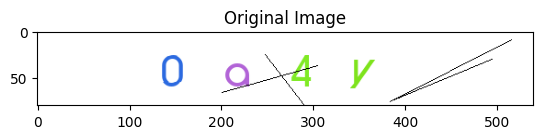

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# --- Step A: Load and Display the Original Image ---

# Let's pick a sample image to work with
sample_image_path = "../data/main/train/0a4y-0.png" 

# Load the image using OpenCV
original_image = cv2.imread(sample_image_path)

# Matplotlib expects images in RGB format, but OpenCV loads them in BGR.
# We need to convert it to display the colors correctly.
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

print(f"Original image shape: {original_image.shape}") # (Height, Width, Channels)
plt.imshow(rgb_image)
plt.title("Original Image")
plt.show()

Grayscale image shape: (80, 540)


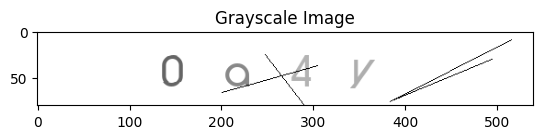

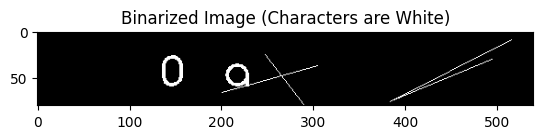

In [10]:
# --- Step B: Convert to Grayscale --- FAILED!!! DO NOT USE THIS
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

print(f"Grayscale image shape: {gray_image.shape}")
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.show()


# --- Step C: Binarize the image using Otsu's Thresholding ---
# This converts the image to pure black and white, removing noise.
# THRESH_BINARY_INV makes the characters white (255) and background black (0).
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(binary_image, cmap='gray')
plt.title("Binarized Image (Characters are White)")
plt.show()

In [5]:
import os
import glob
import cv2

# --- Find the maximum width needed for our images ---

train_image_paths = glob.glob("../data/main/train/*.png")
IMG_HEIGHT = 50
max_width = 0

print("Calculating maximum image width...")

for path in train_image_paths:
    # Load image just to get its dimensions
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded correctly
    if img is None:
        print(f"Warning: Could not load image {path}")
        continue
        
    h, w = img.shape
    
    # Calculate the new width after resizing to IMG_HEIGHT
    scale_factor = IMG_HEIGHT / h
    new_w = int(w * scale_factor)
    
    # Update the maximum width if this one is larger
    if new_w > max_width:
        max_width = new_w

print(f"\nMaximum resized image width found: {max_width}")
# Let's use a slightly larger, round number for safety
IMG_WIDTH = max_width + 8 # Add a little padding
print(f"Using IMG_WIDTH = {IMG_WIDTH} for our model.")

Calculating maximum image width...

Maximum resized image width found: 487
Using IMG_WIDTH = 495 for our model.



Final image shape for model: (495, 50, 1)


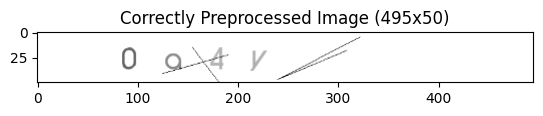

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# This function is now correct because IMG_WIDTH is defined above
def prepare_image_for_crnn(image_path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    """Loads and prepares an image for the CRNN model."""
    
    # 1. Read image and convert to grayscale.
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 2. Resize to fixed height, maintaining aspect ratio.
    h, w = img.shape
    scale = img_height / h
    new_w = int(w * scale)
    img = cv2.resize(img, (new_w, img_height))
    
    # 3. Pad the image to the target width.
    target = np.ones((img_height, img_width)) * 255 # White padding
    # This line will now work correctly
    target[:, :new_w] = img
    
    # 4. Normalize pixel values to [0, 1] range.
    img = target.astype(np.float32) / 255.0
    
    # 5. Transpose for the RNN.
    img = np.transpose(img, (1, 0))
    
    # 6. Add the channel dimension.
    img = np.expand_dims(img, axis=-1)
    
    return img

# --- Test and Visualize ---
sample_image_path = "../data/main/train/0a4y-0.png"
processed_img = prepare_image_for_crnn(sample_image_path)

print(f"\nFinal image shape for model: {processed_img.shape}")

# To visualize, we need to undo the transpose and remove the last dimension
plt.imshow(np.transpose(processed_img[:, :, 0], (1, 0)), cmap='gray')
plt.title(f"Correctly Preprocessed Image ({IMG_WIDTH}x{IMG_HEIGHT})")
plt.show()

Displaying 10 random samples...


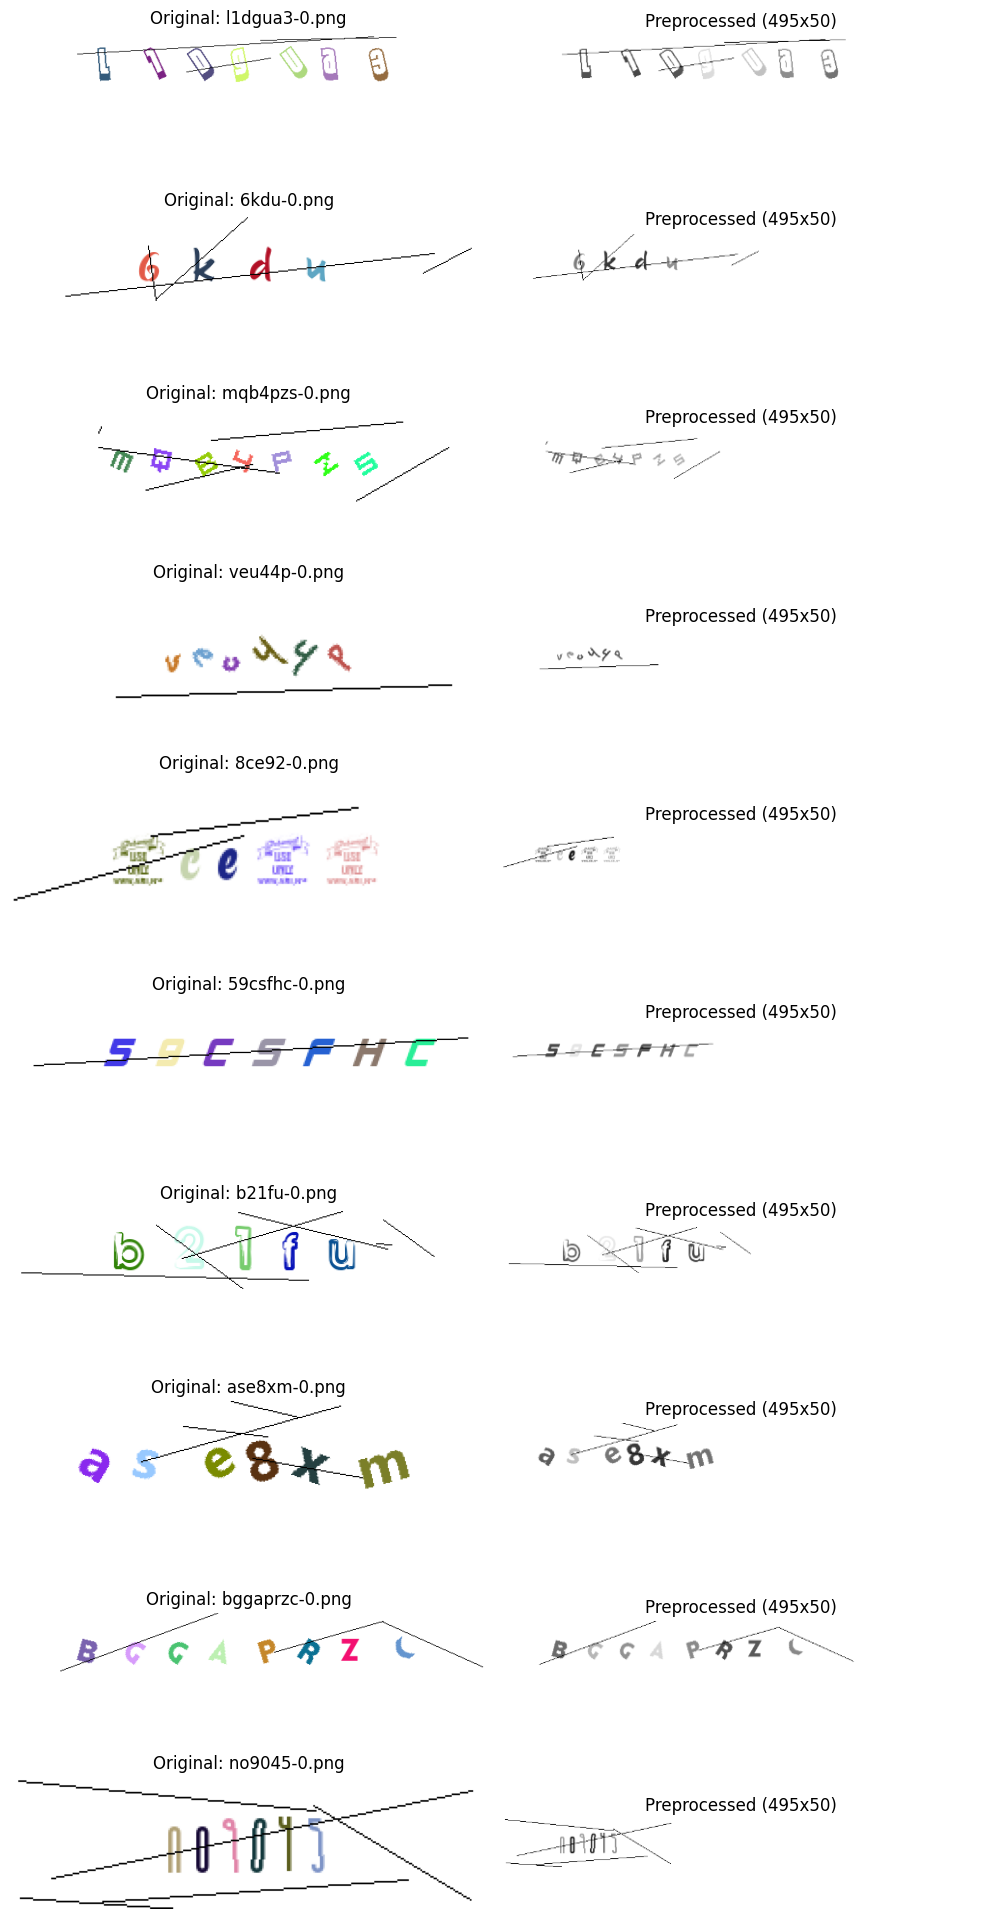

In [9]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Get all image paths and select 10 random samples ---

# Make sure these are defined from your previous cell
# IMG_WIDTH = ...
# IMG_HEIGHT = ...

all_train_paths = glob.glob("../data/main/train/*.png")
num_samples_to_show = 10
random_sample_paths = random.sample(all_train_paths, num_samples_to_show)

print(f"Displaying {num_samples_to_show} random samples...")

# --- Step 2: Create a figure to display the results ---
# We create a grid of subplots: 10 rows, 2 columns
fig, axes = plt.subplots(nrows=num_samples_to_show, ncols=2, figsize=(10, 20))

# --- Step 3: Loop through the random samples and process/display them ---

for i, image_path in enumerate(random_sample_paths):
    
    # --- Left Column: The Original Image ---
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    ax = axes[i, 0]
    ax.imshow(rgb_img)
    ax.set_title(f"Original: {os.path.basename(image_path)}")
    ax.axis('off') # Hide the x and y axes
    
    
    # --- Right Column: The Preprocessed Image ---
    
    # Use the function you already created!
    processed_img = prepare_image_for_crnn(image_path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT)
    
    # To display the processed image, we need to undo the transpose and remove the channel dimension
    # Shape goes from (width, height, 1) -> (width, height) -> (height, width)
    display_img = np.transpose(processed_img.squeeze(), (1, 0))

    ax = axes[i, 1]
    ax.imshow(display_img, cmap='gray')
    ax.set_title(f"Preprocessed ({IMG_WIDTH}x{IMG_HEIGHT})")
    ax.axis('off')

# Adjust layout to prevent titles from overlapping and show the plot
plt.tight_layout()
plt.show()